### Train and tune LGBM using ADS ADSTuner

see: https://accelerated-data-science.readthedocs.io/en/latest/user_guide/model_training/ads_tuner.html#

* https://lightgbm.readthedocs.io/en/v3.3.2/
* applicato al caso **customer churn**
* usa: generalml_ come ambiente conda
* (23/03): switched to p38

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import imblearn

from sklearn.metrics import classification_report
from sklearn.metrics import (get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# ADS tuner
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *

# to rebalance
from imblearn.over_sampling import RandomOverSampler

from utils import (cat_cols_selector,
                  num_cols_selector,
                  plot_cm,
                  evaluate_metrics)

%matplotlib inline

#### Legge i dati dall'Object Storage

In [2]:
NAMESPACE = "frqap2zhtzbe"
BUCKET = "WORKSHOP"
NOME_FILE = "customer_churn_data.csv"

URL = f"oci://{BUCKET}@{NAMESPACE}/{NOME_FILE}"

orig_df = pd.read_csv(URL)

orig_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Data Preparation, Feature Engineering

In [3]:
# get rid of some columns
cols_to_drop = ['customerID', 'TotalCharges']

df = orig_df.drop(columns=cols_to_drop)

TARGET = "Churn"
features = list(set(df.columns) - set([TARGET]))

In [4]:
# identify categorical and continuous
cat_cols = cat_cols_selector(df, TARGET)
num_cols = num_cols_selector(df, TARGET)

In [5]:
# code categorical as integer for LightGBM
enc = OrdinalEncoder()
enc.fit(df[cat_cols])

df[cat_cols] = enc.transform(df[cat_cols])

for col in cat_cols:
    df[col] = df[col].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [7]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,No
1,1.0,0.0,0.0,0.0,34,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,No
2,1.0,0.0,0.0,0.0,2,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,Yes
3,1.0,0.0,0.0,0.0,45,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,No
4,0.0,0.0,0.0,0.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,Yes


#### Train/test split

In [8]:
# train, test split (lo faccio direttamente sui dataframe)
SEED = 42

TEST_FRAC = 0.2

df_train, df_test = train_test_split(df, shuffle=True, test_size=TEST_FRAC, 
                                     random_state = SEED)

X_train, y_train = df_train.drop([TARGET], axis=1), df_train[TARGET]
X_test, y_test = df_test.drop([TARGET], axis=1), df_test[TARGET]

print()
print("Summary on train/test dataset:")
print()
print("# of samples in train set", df_train.shape[0])
print("# of samples in test set", df_test.shape[0])
print()
print(f'Numerical columns: {num_cols} ({len(num_cols)})')
print()
print(f'Categorical columns: {cat_cols} ({len(cat_cols)})')


Summary on train/test dataset:

# of samples in train set 5634
# of samples in test set 1409

Numerical columns: ['tenure', 'MonthlyCharges'] (2)

Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] (16)


#### HPO sul dataset non bilanciato

In [9]:
#
# definisco la pipeline completa
#
N_TRIALS = 50

# metrics on which to optimize
scorer = make_scorer(accuracy_score)

# i parametri che vogliamo fissare
params = {
    # info
    "verbose" : 0,
}

# qui definisco la strategia per HPO
strategy = {"num_leaves" : IntUniformDistribution(5, 24, 1),
           'max_depth': IntUniformDistribution(2, 10, 1),
            'n_estimators': IntUniformDistribution(50, 200, 10),
            'learning_rate' : LogUniformDistribution(low=1e-03, high=1e-1),
            }

# non abbiamo bisogno di scalare perchè è un GBM
model = lgb.LGBMClassifier(**params)

In [10]:
tuner = ADSTuner(model, cv=5, n_jobs=2, strategy=strategy, scoring=scorer, random_state=SEED)

tuner.tune(X_train, y_train, exit_criterion=[NTrials(N_TRIALS)])

[I 2023-03-23 08:32:59,223] A new study created in RDB with name: hpo_6aab148a-0344-495e-a36e-01554f4484ee


In [35]:
print(f"Number of trials launched: {len(tuner.trials)}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Number of trials launched: 46


In [67]:
tuner.trials.sort_values(by=["value"], ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,user_attrs_mean_fit_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
21,21,0.840627,2023-03-23 08:39:58.964132,2023-03-23 08:40:21.056685,0 days 00:00:22.092553,0.093080,15,200,22,4.350960,...,accuracy_score,0.812198,0.830211,0.847734,0.850755,0.862236,0.042342,0.004079,0.017531,COMPLETE
44,44,0.839056,2023-03-23 08:43:38.256681,2023-03-23 08:43:58.532441,0 days 00:00:20.275760,0.097942,13,180,22,3.996618,...,accuracy_score,0.807971,0.835650,0.842296,0.854381,0.854985,0.090821,0.003607,0.017187,COMPLETE
39,39,0.836760,2023-03-23 08:42:47.720276,2023-03-23 08:43:09.169153,0 days 00:00:21.448877,0.096718,14,190,22,4.220495,...,accuracy_score,0.808575,0.822356,0.841692,0.851964,0.859215,0.109540,0.002285,0.018770,COMPLETE
24,24,0.836278,2023-03-23 08:40:21.078057,2023-03-23 08:40:40.711861,0 days 00:00:19.633804,0.097700,10,180,22,3.864211,...,accuracy_score,0.802536,0.833837,0.841692,0.847734,0.855589,0.069304,0.003503,0.018319,COMPLETE
34,34,0.833860,2023-03-23 08:41:58.928496,2023-03-23 08:42:18.558478,0 days 00:00:19.629982,0.098832,11,170,23,3.861250,...,accuracy_score,0.809783,0.826586,0.832628,0.843505,0.856798,0.039097,0.003746,0.015832,COMPLETE


In [41]:
tuner.status

<State.COMPLETED: 5>

In [42]:
tuner.best_params

{'learning_rate': 0.05513080388804163,
 'max_depth': 4,
 'n_estimators': 80,
 'num_leaves': 13}

#### Addestriamo il modello con i best params

In [43]:
params = tuner.best_params

model = lgb.LGBMClassifier(**params)

In [44]:
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05513080388804163, max_depth=4, n_estimators=80,
               num_leaves=13)

#### Evaluation

In [45]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.8148, 'roc_auc': 0.8618}


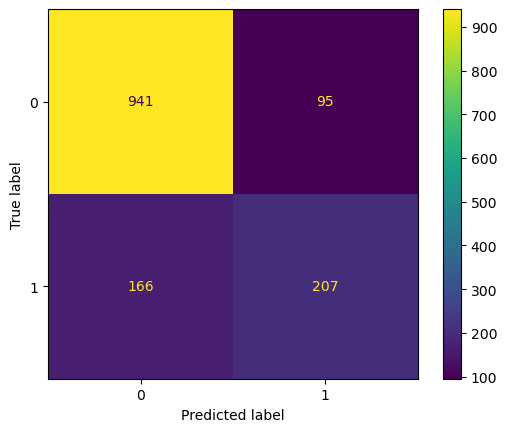

In [46]:
plot_cm(model, X_test, y_test)

#### Rebalance: vediamo che bilanciando il dataset si ottiene un risultato migliore riducendo i FN

In [47]:
SEED = 42

# we use a simple RandomSampler from imblearn
ros = RandomOverSampler(random_state=SEED)

In [48]:
# bilanciamo solo il training set, il test set NON è toccato
X_train_reb, y_train_reb = ros.fit_resample(X_train, y_train)

In [49]:
params = {
    # info
    "verbose" : 0,
}

strategy = {"num_leaves" : IntUniformDistribution(15, 24, 1),
            'max_depth': IntUniformDistribution(5, 15, 1),
            'n_estimators': IntUniformDistribution(50, 200, 10),
            'learning_rate' : LogUniformDistribution(low=1e-03, high=1e-1),
            }

model = lgb.LGBMClassifier(**params)

In [50]:
tuner = ADSTuner(model, cv=5, n_jobs=2, strategy=strategy, scoring=scorer, random_state=SEED) ## cv is cross validation splits

tuner.tune(X_train_reb, y_train_reb, exit_criterion=[NTrials(N_TRIALS)])

In [65]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 50


In [68]:
tuner.trials.sort_values(by=["value"], ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,user_attrs_mean_fit_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
21,21,0.840627,2023-03-23 08:39:58.964132,2023-03-23 08:40:21.056685,0 days 00:00:22.092553,0.093080,15,200,22,4.350960,...,accuracy_score,0.812198,0.830211,0.847734,0.850755,0.862236,0.042342,0.004079,0.017531,COMPLETE
44,44,0.839056,2023-03-23 08:43:38.256681,2023-03-23 08:43:58.532441,0 days 00:00:20.275760,0.097942,13,180,22,3.996618,...,accuracy_score,0.807971,0.835650,0.842296,0.854381,0.854985,0.090821,0.003607,0.017187,COMPLETE
39,39,0.836760,2023-03-23 08:42:47.720276,2023-03-23 08:43:09.169153,0 days 00:00:21.448877,0.096718,14,190,22,4.220495,...,accuracy_score,0.808575,0.822356,0.841692,0.851964,0.859215,0.109540,0.002285,0.018770,COMPLETE
24,24,0.836278,2023-03-23 08:40:21.078057,2023-03-23 08:40:40.711861,0 days 00:00:19.633804,0.097700,10,180,22,3.864211,...,accuracy_score,0.802536,0.833837,0.841692,0.847734,0.855589,0.069304,0.003503,0.018319,COMPLETE
34,34,0.833860,2023-03-23 08:41:58.928496,2023-03-23 08:42:18.558478,0 days 00:00:19.629982,0.098832,11,170,23,3.861250,...,accuracy_score,0.809783,0.826586,0.832628,0.843505,0.856798,0.039097,0.003746,0.015832,COMPLETE


In [69]:
tuner.best_params

{'learning_rate': 0.09307994963376318,
 'max_depth': 15,
 'n_estimators': 200,
 'num_leaves': 22}

In [70]:
params = tuner.best_params

model = lgb.LGBMClassifier(**params)

In [71]:
model.fit(X_train_reb, y_train_reb)

LGBMClassifier(learning_rate=0.09307994963376318, max_depth=15,
               n_estimators=200, num_leaves=22)

In [72]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.7807, 'roc_auc': 0.8474}


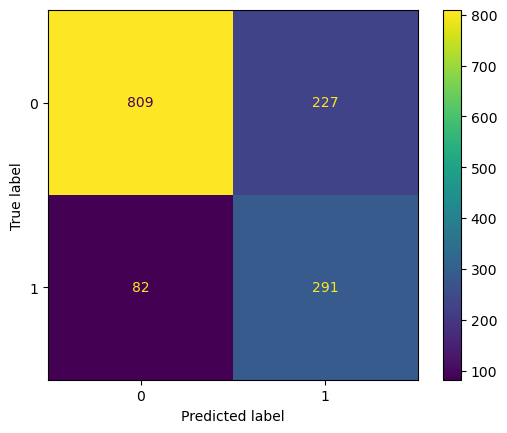

In [73]:
plot_cm(model, X_test, y_test)

#### Some plots

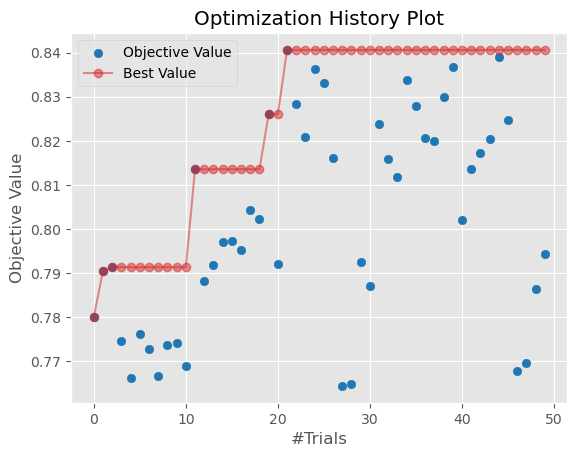

In [74]:
tuner.plot_best_scores()

In [75]:
tuner.search_space()

{'num_leaves': IntUniformDistribution(low=15, high=24, step=1),
 'max_depth': IntUniformDistribution(low=5, high=15, step=1),
 'n_estimators': IntUniformDistribution(low=50, high=200, step=10),
 'learning_rate': LogUniformDistribution(low=0.001, high=0.1)}

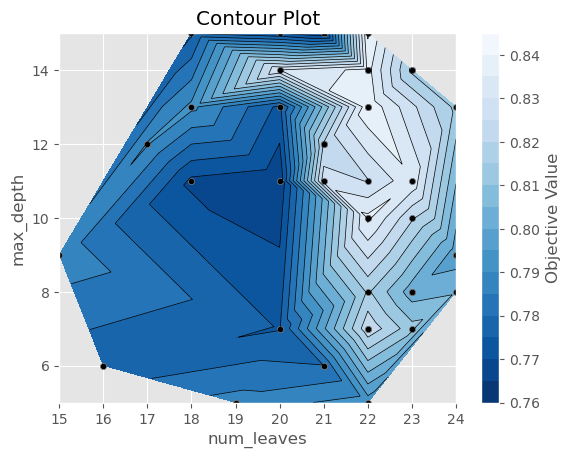

In [76]:
tuner.plot_contour_scores(params=['num_leaves', 'max_depth'])